# Experiment Report Notebook

This notebook summarizes the experiments conducted to compare various Python libraries for processing DOCX files.



## Section 1: Introduction
In this notebook, we will:
1. Provide an overview of the libraries tested.
2. Benchmark their performance in extracting information from DOCX files.
    - Time performance
    - Extraction quality performance
3. Visualize the results and draw comparisons.
4. Summarize findings and highlight the strengths and weaknesses of each library.
    - Analyze library integrations with frameworks such as LangChain.

We summarize below the libraries that are tested in thisn  notebook:

### Overview of Libraries
| Library                   | DOCX Conversion Engine | Conversion to Markdown | Conversion to HTML | Integration with LangChain | Price                  |
|---------------------------|-------------------------|-------------------------|--------------------|---------------------------|-----------------------|
| **[Unstructured](https://unstructured.io/)**          | python-docx            | ✅                     | ❌                | ✅                       | Free Tier             |
| **[Pymupdf](https://pymupdf.readthedocs.io/en/latest/)**               | MuPDF (commercial add-on) | ❌                      | ❌                 | ❌                        | Requires Pro version  |
| **[MarkItDown](https://github.com/microsoft/markitdown)**            | python-docx            | ✅                     | ❌                 | 🤔 (LLMs only)           | Free                  |
| **[Docling](https://github.com/DS4SD/docling)**               | python-docx            | ✅                     | ✅                | ✅                       | Free                  |
| **[Everything2Markdown](https://github.com/wisupai/e2m)**   | Internal parser        | ✅                     | ❌                 | ❌                        | Free                  |
| **[PyPandoc](https://github.com/JessicaTegner/pypandoc)**              | pandoc                 | ✅                     | ✅                | ❌                        | Free                  |
| **[docx2txt](https://github.com/ankushshah89/python-docx2txt)**              | Internal parser (xml2text-based)        | ✅                     | ❌                 | ❌                        | Free                  |
| **[docxpy](https://github.com/badbye/docxpy)**                | Internal parser  (xml2text-based)      | ✅                     | ❌                 | ❌                        | Free                  |


In [1]:
import time
import glob
import matplotlib.pyplot as plt
import pypandoc
import docx2txt
import docxpy
from docx import Document

from unstructured.partition.docx import partition_docx as unstructured_partition
from langchain_community.document_loaders.word_document import (
    UnstructuredWordDocumentLoader,
    Docx2txtLoader,
    )
from markitdown import MarkItDown
from wisup_e2m import DocxParser
from docling.document_converter import DocumentConverter
from langchain_docling import DoclingLoader

from langchain_docling.loader import ExportType


/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/pydantic/_internal/_config.py:295: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.10/migration/
  warnings.warn(DEPRECATION_MESSAGE, DeprecationWarning)
/Users/jabreu/PycharmProjects/python-playground/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from unstructured.partition.docx import partition_docx

import ssl
import urllib.request

#######
### ONLY FOR TESTING PURPOSES! ! ! !  NEVER IN PROD
ssl._create_default_https_context = ssl._create_unverified_context


In [3]:
from glob import glob
import os
from dotenv import load_dotenv

load_dotenv()  # Load .env file
import pymupdf.pro
pymupdf.pro.unlock(os.getenv('PYMUPDF_KEY'))

DOCX_FILES = glob('./data/docx/*')
GROUND_TRUTH = glob('./data/ground_truth/*')


# Organize the list of files making sure that the same file names are in the same index
DOCX_FILES.sort()
GROUND_TRUTH.sort()

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


PyMuPDFPro: Trial Mode, 58 days 11 hours left.


## Section 2 - Time comparison

In [4]:
# PyPanDoc

def process_with_pypandoc_md(file):
    return pypandoc.convert_file(file, 'markdown')

def process_with_pypandoc_html(file):
    return pypandoc.convert_file(file, 'html')

# PyMUPDF
import pymupdf4llm
def process_with_pymupdf_md(file):
    return pymupdf4llm.to_markdown(file)

from langchain_community.document_loaders import PyMuPDFLoader
def process_with_pymupdf_langchain(file):
    loader = PyMuPDFLoader(file)
    return loader.load()

# MarkItDown
def process_with_markitdown_md(file):
    md = MarkItDown()
    return md.convert(file)

# Docling
def process_with_docling_md(file):
    converter = DocumentConverter()
    docling_docx = converter.convert(file)
    return docling_docx.document.export_to_markdown()

def process_with_docling_html(file):
    converter = DocumentConverter()
    docling_docx = converter.convert(file)
    return docling_docx.document.export_to_html()

def process_with_docling_langchain(file):
    loader = DoclingLoader(file_path=file)
    return loader.load()

# Wisup E2M

def process_with_wisup_e2m_pandoc(file):
    parser = DocxParser(engine="pandoc") # docx engines: pandoc, xml
    docx_data = parser.parse(file)
    return docx_data.text

def process_with_wisup_e2m_xml(file):
    parser = DocxParser(engine="xml") # docx engines: pandoc, xml
    docx_data = parser.parse(file)
    return docx_data.text

# unstructured
def process_with_unstructured_md(file):
    return partition_docx(filename=file)

def process_with_unstructured_langchain(file):
    loader = UnstructuredWordDocumentLoader(file)
    return loader.load()

#docx2txt loader

def process_with_docx2txt_langchain(file):
    loader = Docx2txtLoader(file)
    return loader.load()

def process_with_docx2txt(file):
    return docx2txt.process(file)

# docxpy
def process_with_docxpy(file):
    # if you want the hyperlinks
    doc = docxpy.DOCReader(file)
    return doc.process()  # process file

In [5]:
def benchmark_library(library_function):
    """
    Benchmark a library function
    """
    start_time = time.time()
    for file in DOCX_FILES:
        library_function(file)
    return time.time() - start_time


In [6]:
# Measure performance.
library_timings = {
    "convert_to_markdown":{
    "Docling": benchmark_library(process_with_docling_md),
    "Unstructured": benchmark_library(process_with_unstructured_md),
    "MarkItDown": benchmark_library(process_with_markitdown_md),
    "Everything2Markdown_pandoc": benchmark_library(process_with_wisup_e2m_pandoc),
    "Everything2Markdown_xml": benchmark_library(process_with_wisup_e2m_xml),
    "PyPandoc": benchmark_library(process_with_pypandoc_md),
    "PyMuPDF": benchmark_library(process_with_pymupdf_md),
    "Docx2txt": benchmark_library(process_with_docx2txt),
    "Docxpy": benchmark_library(process_with_docxpy),
    },
    "convert_to_html":{
    "Docling": benchmark_library(process_with_docling_html),
    "PyPandoc": benchmark_library(process_with_pypandoc_html),
    },
    "langchain_loaders":{
    "Docling": benchmark_library(process_with_docling_langchain),
    "Unstructured": benchmark_library(process_with_unstructured_langchain),
    "Docx2txt": benchmark_library(process_with_docx2txt_langchain),
    "PyMuPDF": benchmark_library(process_with_pymupdf_langchain),
    },
    
}

[WARNING] Could not convert TeX math Eccentricity\  = \ \frac{\sqrt{a^{2} - b^{2}}}{a}, rendering as TeX
[WARNING] Could not convert TeX math Junctional\ linearization\ index\  = \ \frac{exact\ contour\ of\ the\ cell}{convex\ perimeter}, rendering as TeX

[WARNING] Could not convert TeX math \begin{matrix}
  F = \int_{}^{}{\left( f_{int} + f_{ent} \right)dV},\#(1) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{int} = \frac{\sigma}{2}\left( \nabla\phi_{ad} \right)^{2} - \chi_{self}\phi_{ad}^{2} - \chi_{Ub}\phi_{Ub}\phi_{ad} + \chi_{Mt}\phi_{Mt}\phi_{ad},\#(2) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{ent} = \phi_{ad}\ln\phi_{ad} + \phi_{sol}\ln\phi_{sol},\#(3) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{int} = \frac{\sigma}{2}\left( \nabla\phi_{ad} \right)^{2} - \chi_{self}\phi_{ad}^{2} - \chi_{Ub}\phi_{Ub}\phi_{ad} - \chi_{LC3}\phi_{LC3}\phi_

ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text='Latrophilin-2 mediates fluid shear stress mechanotransduction at endothelial junctions'
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text=''
ele.tag='{http://schemas.openxmlformats.org/wordprocessingml/2006/main}p' | ele.text='Keiichiro Tanaka1,7,*, Minghao Chen1,7, Andrew Prendergast1, Zhenwu Zhuang1, Ali Nasiri2, Divyesh Joshi1, Jared Hintzen1, Minhwan Chung1, Abhishek Kumar1, Arya Mani1, Anthony Koleske3, Jason Crawford4, Stefania N

[WARNING] Could not convert TeX math Eccentricity\  = \ \frac{\sqrt{a^{2} - b^{2}}}{a}, rendering as TeX
[WARNING] Could not convert TeX math Junctional\ linearization\ index\  = \ \frac{exact\ contour\ of\ the\ cell}{convex\ perimeter}, rendering as TeX

[WARNING] Could not convert TeX math \begin{matrix}
  F = \int_{}^{}{\left( f_{int} + f_{ent} \right)dV},\#(1) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{int} = \frac{\sigma}{2}\left( \nabla\phi_{ad} \right)^{2} - \chi_{self}\phi_{ad}^{2} - \chi_{Ub}\phi_{Ub}\phi_{ad} + \chi_{Mt}\phi_{Mt}\phi_{ad},\#(2) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{ent} = \phi_{ad}\ln\phi_{ad} + \phi_{sol}\ln\phi_{sol},\#(3) \\
  \end{matrix}, rendering as TeX
[WARNING] Could not convert TeX math \begin{matrix}
  f_{int} = \frac{\sigma}{2}\left( \nabla\phi_{ad} \right)^{2} - \chi_{self}\phi_{ad}^{2} - \chi_{Ub}\phi_{Ub}\phi_{ad} - \chi_{LC3}\phi_{LC3}\phi_

In [9]:
# Merge timings
all_timings = {**library_timings}

# Section 7: Improved Visualization

# Extract specific benchmarks for Markdown, HTML, and LangChain loaders
markdown_timings = library_timings["convert_to_markdown"]
html_timings = library_timings["convert_to_html"]
langchain_timings = library_timings["langchain_loaders"]


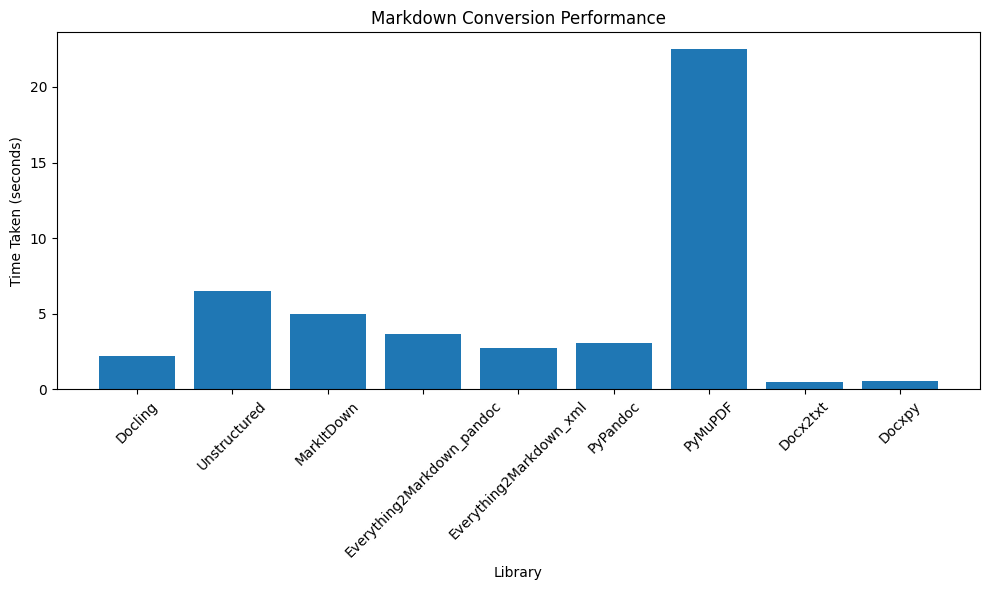

In [10]:
# Plot Markdown Conversion Performance
plt.figure(figsize=(10, 6))
plt.bar(markdown_timings.keys(), markdown_timings.values())
plt.xlabel("Library")
plt.ylabel("Time Taken (seconds)")
plt.title("Markdown Conversion Performance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


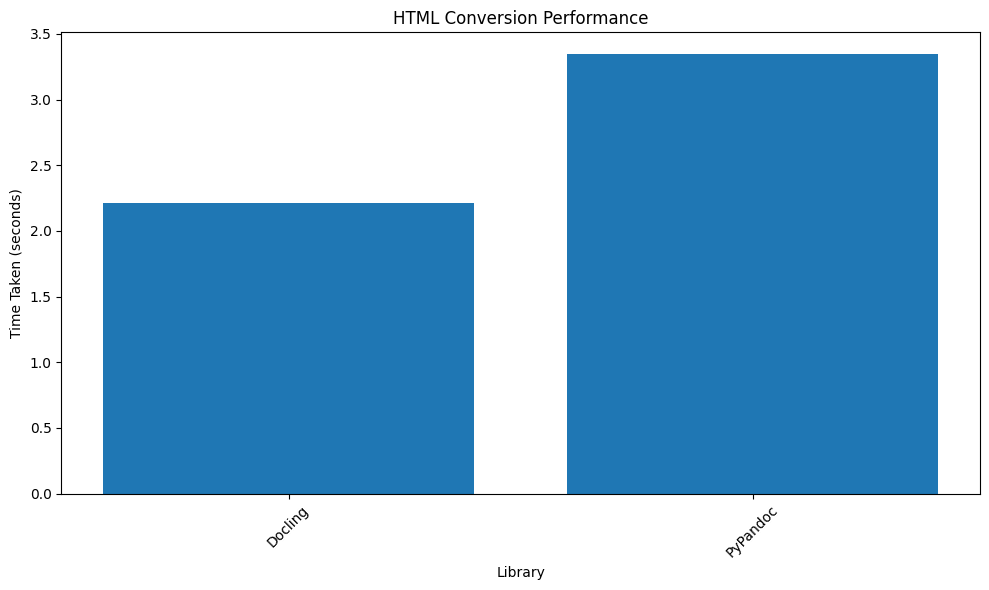

In [11]:
# Plot HTML Conversion Performance
plt.figure(figsize=(10, 6))
plt.bar(html_timings.keys(), html_timings.values())
plt.xlabel("Library")
plt.ylabel("Time Taken (seconds)")
plt.title("HTML Conversion Performance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



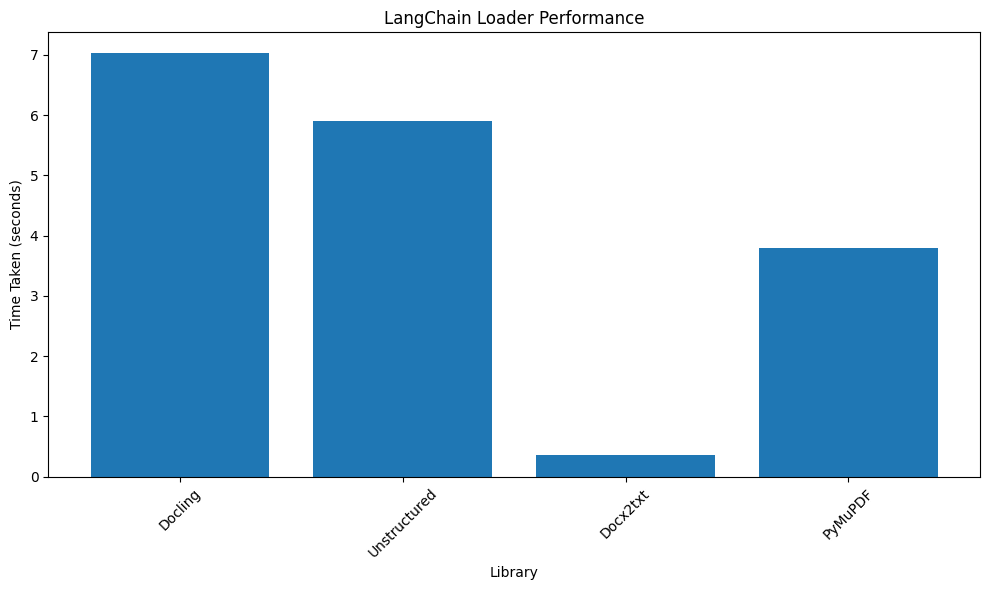

In [12]:
# Plot LangChain Loader Performance
plt.figure(figsize=(10, 6))
plt.bar(langchain_timings.keys(), langchain_timings.values())
plt.xlabel("Library")
plt.ylabel("Time Taken (seconds)")
plt.title("LangChain Loader Performance")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
